In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# import sys
# sys.path.insert(0, '../')
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"


import numpy as np
import tensorflow as tf

from gantools import data
from gantools import utils
from gantools import plot
from gantools.model import CosmoWGAN, WGAN, LapWGAN, UpscalePatchWGAN
from gantools.gansystem import GANsystem, UpscaleGANsystem
from gantools.data import fmap
from gantools import evaluation
import functools
import matplotlib.pyplot as plt
from copy import deepcopy

# Parameters

In [3]:
ns = 32 # Resolution of the image
try_resume = True # Try to resume previous simulation
Mpch = 350 # Type of dataset (select 70 or 350)

# Do not change these for now
# shift = 3
# c = 40000
# forward = functools.partial(fmap.stat_forward, shift=shift, c=c)
# backward = functools.partial(fmap.stat_backward, shift=shift, c=c)

forward = fmap.stat_forward
backward = fmap.stat_backward

# Data handling

Load the data

In [4]:
dataset = data.load.load_nbody_dataset(nsamples=10, spix=ns, Mpch=Mpch, forward_map=forward, patch=True, is_3d=False)

Select 10 samples out of 30.
images shape =  (10, 256, 256, 256)


In [5]:
# The dataset can return an iterator.
it = dataset.iter(10)
print(next(it).shape)
del it

(10, 32, 32, 4)


In [6]:
# Get all the data
X = dataset.get_all_data()[:,:,:,0].flatten()

In [7]:
# Check that the backward maps invert the forward map.
# assert(np.sum(np.abs(forward(backward(X))-X))< 5)
# # For debugging
# np.sum(np.abs(forward(backward(X))-X))
# forward(backward(X))-X
# x = np.arange(1e4)
# plt.plot(x, backward(forward(x))-x)

In [8]:
np.sum(np.abs(forward(backward(X))-X))

2.0770593

Display the histogram of the pixel densities after the forward map

min: 0.0
max: 6.077099323272705


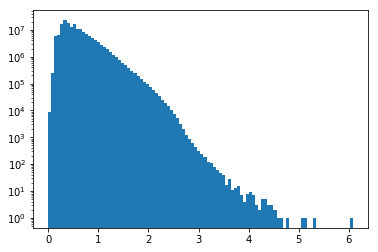

In [9]:
plt.hist(X, 100)
print('min: {}'.format(np.min(X)))
print('max: {}'.format(np.max(X)))
plt.yscale('log')

In [10]:
# to free some memory
del X

Let us plot 16 images

Text(0.5,1,'Real samples')

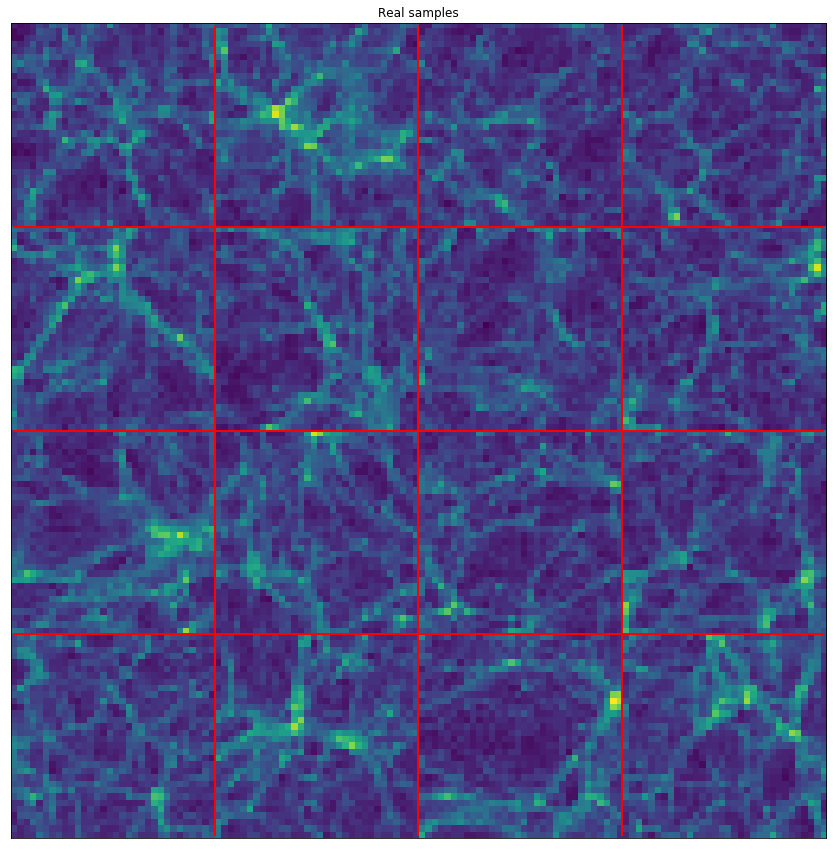

In [11]:
plt.figure(figsize=(15,15))
plot.draw_images(dataset.get_samples(N=16)[:,:,:,0],nx=4,ny=4);
plt.title("Real samples")

# Define parameters for the WGAN

In [13]:
time_str = '2D_patchgan_uniscale'
global_path = 'saved_results'

name = 'WGAN{}'.format(ns) + '_' + time_str

## Parameters

In [14]:
bn = False

md=32

params_discriminator = dict()

params_discriminator['stride'] = [2, 2, 2, 1, 1, 1]
params_discriminator['nfilter'] = [2*md, 2*md, md, md//2, md//4,2]
params_discriminator['shape'] = [[4, 4],[4, 4], [4, 4],[4, 4], [4, 4], [4, 4]]
params_discriminator['batch_norm'] = [bn, bn, bn, bn, bn, bn]
params_discriminator['full'] = [64, 16]
params_discriminator['minibatch_reg'] = False
params_discriminator['summary'] = True
params_discriminator['data_size'] = 2
params_discriminator['inception'] = True
params_discriminator['spectral_norm'] = False

params_generator = dict()
params_generator['stride'] = [1, 1, 1, 1, 1, 1, 1, 1]
params_generator['latent_dim'] = 32*32
params_generator['latent_dim_split'] = None
params_generator['in_conv_shape'] =[32, 32]
params_generator['nfilter'] = [md, md, md, md, md, md, md, 1]
params_generator['shape'] = [[4, 4],[4, 4], [4, 4],[4, 4], [4, 4], [4, 4]]
params_generator['batch_norm'] = [bn, bn, bn, bn,bn, bn, bn]
params_generator['full'] = []
params_generator['summary'] = True
params_generator['non_lin'] = tf.nn.relu
params_generator['data_size'] = 2
params_generator['inception'] = True
params_generator['spectral_norm'] = False
params_generator['use_Xdown'] = False
params_generator['weights_border'] = True


# Optimization parameters inspired from 'Self-Attention Generative Adversarial Networks'
# - Spectral normalization GEN DISC
# - Batch norm GEN
# - TTUR ('GANs Trained by a Two Time-Scale Update Rule Converge to a Local Nash Equilibrium')
# - ADAM  beta1=0 beta2=0.9, disc lr 0.0004, gen lr 0.0001
# - Hinge loss
# Parameters are similar to the ones in those papers...
# - 'PROGRESSIVE GROWING OF GANS FOR IMPROVED QUALITY, STABILITY, AND VARIATION'
# - 'LARGE SCALE GAN TRAINING FOR HIGH FIDELITY NATURAL IMAGE SYNTHESIS'
# - 'CGANS WITH PROJECTION DISCRIMINATOR'

params_optimization = dict()
params_optimization['batch_size'] = 8
params_optimization['epoch'] = 100
params_optimization['n_critic'] = 5
# params_optimization['generator'] = dict()
# params_optimization['generator']['optimizer'] = 'adam'
# params_optimization['generator']['kwargs'] = {'beta1':0, 'beta2':0.9}
# params_optimization['generator']['learning_rate'] = 0.0004
# params_optimization['discriminator'] = dict()
# params_optimization['discriminator']['optimizer'] = 'adam'
# params_optimization['discriminator']['kwargs'] = {'beta1':0, 'beta2':0.9}
# params_optimization['discriminator']['learning_rate'] = 0.0001

# Cosmology parameters
params_cosmology = dict()
params_cosmology['forward_map'] = forward
params_cosmology['backward_map'] = backward


# all parameters
params = dict()
params['net'] = dict() # All the parameters for the model
params['net']['generator'] = params_generator
params['net']['discriminator'] = params_discriminator
params['net']['cosmology'] = params_cosmology # Parameters for the cosmological summaries
params['net']['prior_distribution'] = 'gaussian'
params['net']['shape'] = [ns, ns, 4] # Shape of the image
params['net']['loss_type'] = 'normalized_wasserstein' # loss ('hinge' or 'wasserstein')
params['net']['gamma_gp'] = 10 # Gradient penalty

params['optimization'] = params_optimization
params['summary_every'] = 200 # Tensorboard summaries every ** iterations
params['print_every'] = 50 # Console summaries every ** iterations
params['save_every'] = 1000 # Save the model every ** iterations
params['summary_dir'] = os.path.join(global_path, name +'_summary/')
params['save_dir'] = os.path.join(global_path, name + '_checkpoints/')
params['Nstats'] = 1000
params['Nstats_cubes'] = 30






In [15]:
resume, params = utils.test_resume(try_resume, params)
# If a model is reloaded and some parameters have to be changed, then it should be done here.
# For example, setting the number of epoch to 5 would be:
params['optimization']['epoch'] = 5



No resume, the training will start from the beginning!


# Build the model

In [16]:
class CosmoUpscalePatchWGAN(UpscalePatchWGAN, CosmoWGAN):
    pass
wgan = GANsystem(CosmoUpscalePatchWGAN, params)

Apply attenuation to borders
Generator 
--------------------------------------------------
     The input is of size (?, 1024)
     Reshape to (?, 32, 32, 1)
     Contenate with latent variables to (?, 32, 32, 4)
     0 Inception conv(1x1,3x3,5x5) layer with 32 channels
         Non linearity applied
         Size of the variables: (?, 32, 32, 32)
     1 Inception conv(1x1,3x3,5x5) layer with 32 channels
         Non linearity applied
         Size of the variables: (?, 32, 32, 32)
     2 Inception conv(1x1,3x3,5x5) layer with 32 channels
         Non linearity applied
         Size of the variables: (?, 32, 32, 32)
     3 Inception conv(1x1,3x3,5x5) layer with 32 channels
         Non linearity applied
         Size of the variables: (?, 32, 32, 32)
     4 Inception conv(1x1,3x3,5x5) layer with 32 channels
         Non linearity applied
         Size of the variables: (?, 32, 32, 32)
     5 Inception conv(1x1,3x3,5x5) layer with 32 channels
         Non linearity applied
         Size

# Train the model

In [ ]:
wgan.train(dataset, resume=resume)

# Generate new samples
To have meaningful statistics, be sure to generate enough samples
* 2000 : 32 x 32
* 500 : 64 x 64
* 200 : 128 x 128


In [18]:
_, params = utils.test_resume(True, params)
wgan = UpscaleGANsystem(CosmoUpscalePatchWGAN, params)

Resume, the training will start from the last iteration!
Apply attenuation to borders
Generator 
--------------------------------------------------
     The input is of size (?, 1024)
     Reshape to (?, 32, 32, 1)
     Contenate with latent variables to (?, 32, 32, 4)
     0 Inception conv(1x1,3x3,5x5) layer with 32 channels
         Non linearity applied
         Size of the variables: (?, 32, 32, 32)
     1 Inception conv(1x1,3x3,5x5) layer with 32 channels
         Non linearity applied
         Size of the variables: (?, 32, 32, 32)
     2 Inception conv(1x1,3x3,5x5) layer with 32 channels
         Non linearity applied
         Size of the variables: (?, 32, 32, 32)
     3 Inception conv(1x1,3x3,5x5) layer with 32 channels
         Non linearity applied
         Size of the variables: (?, 32, 32, 32)
     4 Inception conv(1x1,3x3,5x5) layer with 32 channels
         Non linearity applied
         Size of the variables: (?, 32, 32, 32)
     5 Inception conv(1x1,3x3,5x5) layer with

In [19]:
from gantools.blocks import downsample

In [20]:
Nsample = 512
X_real = dataset._X[:Nsample]
X_down = downsample(X_real, 4)

In [23]:
X_fake = wgan.upscale_image(N=Nsample, resolution=X_real.shape[1])

 [*] Reading checkpoints...
saved_results/WGAN32_2D_patchgan_uniscale_checkpoints/upscale_patch_wgan-102401
The last checkpoint is found at saved_results/WGAN32_2D_patchgan_uniscale_checkpoints/upscale_patch_wgan-102401
INFO:tensorflow:Restoring parameters from saved_results/WGAN32_2D_patchgan_uniscale_checkpoints/upscale_patch_wgan-102401
Checkpoint successfully loaded!
Current patch: column=1, row=1
Sampling z
Current patch: column=1, row=2
Sampling z
Current patch: column=1, row=3
Sampling z
Current patch: column=1, row=4
Sampling z
Current patch: column=1, row=5
Sampling z
Current patch: column=1, row=6
Sampling z
Current patch: column=1, row=7
Sampling z
Current patch: column=1, row=8
Sampling z
Current patch: column=2, row=1
Sampling z
Current patch: column=2, row=2
Sampling z
Current patch: column=2, row=3
Sampling z
Current patch: column=2, row=4
Sampling z
Current patch: column=2, row=5
Sampling z
Current patch: column=2, row=6
Sampling z
Current patch: column=2, row=7
Samplin

Display a few fake samples

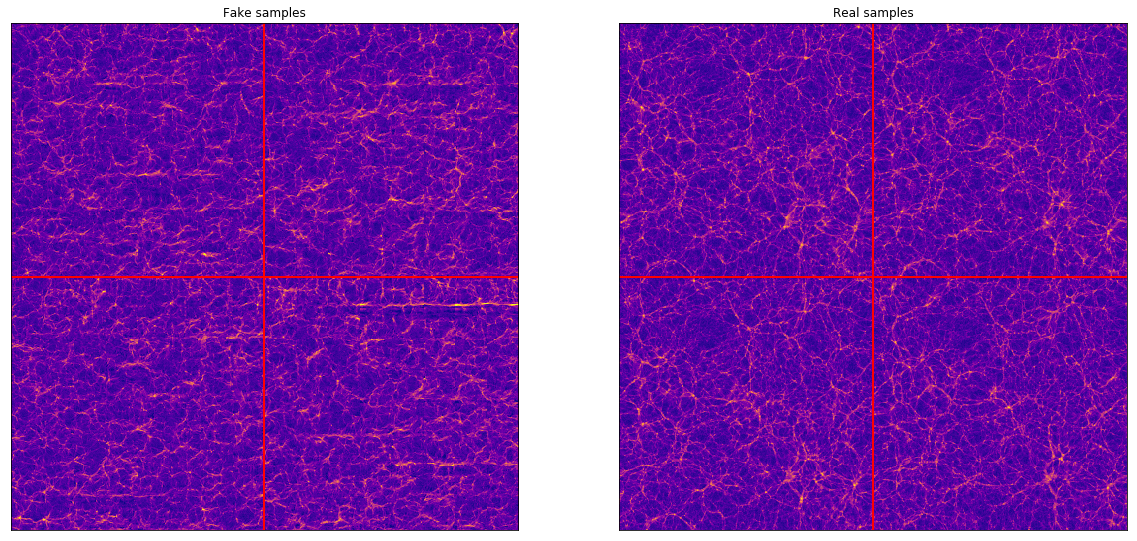

In [31]:
clim = (0,3)
plt.figure(figsize=(20,10))
plt.subplot(121)
plot.draw_images(X_fake,nx=2,ny=2,vmin=clim[0], vmax=clim[1], cmap = plt.cm.plasma);

plt.title("Fake samples");
plt.subplot(122)
plot.draw_images(X_real,nx=2,ny=2,vmin=clim[0], vmax=clim[1], cmap = plt.cm.plasma);
plt.title("Real samples");


# Evaluation of the sample quality

In [26]:
# Before computing the statistics, we need to invert the mapping
raw_images = backward(X_real)
gen_sample_raw = backward(X_fake)

Log l2 PSD loss: 5.081343252059377
L2 PSD loss: 1524.0345938552337
Log l1 PSD loss: 2.158358687204879
L1 PSD loss: 31.296115250798362


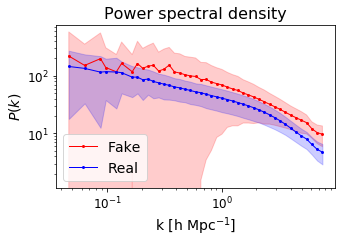

In [27]:
logel2, l2, logel1, l1 = evaluation.compute_and_plot_psd(raw_images, gen_sample_raw)

Log l2 Peak Count loss: 0.05706459526985941
L2 Peak Count loss: 2.4434648590912484e-06
Log l1 Peak Count loss: 0.18268659450542601
L1 Peak Count loss: 0.001369842177849856


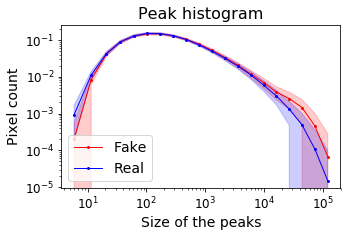

In [28]:
logel2, l2, logel1, l1 = evaluation.compute_and_plot_peak_cout(raw_images, gen_sample_raw)

Log l2 Mass histogram loss: 0.272460090419485
L2 Peak Mass histogram: 0.00015226534893120203
Log l1 Mass histogram loss: 0.263034975690009
L1 Mass histogram loss: 0.005023577809333801


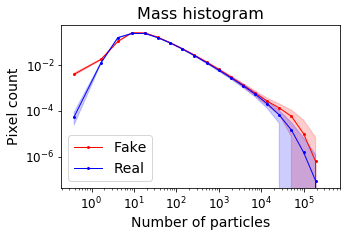

In [29]:
logel2, l2, logel1, l1 = evaluation.compute_and_plot_mass_hist(raw_images, gen_sample_raw)